In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from models import RBM

In [2]:
train = torchvision.datasets.CIFAR10(root="data/", download=True, train=True, transform=transforms.ToTensor())
test = torchvision.datasets.CIFAR10(root="data/", download=True, train=False, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True)

In [4]:
x, y = iter(loader).next()

In [5]:
C, H, W = x.shape[1:]
N_dim = C * H * W
x = x.reshape(-1, N_dim)

In [6]:
D = 128

In [7]:
rbm = RBM(N_dim, D)
optimizer = torch.optim.Adam(lr=0.001, params=rbm.parameters())
MSE = torch.nn.MSELoss()

/home/colors/workspace/deepsym_v2/models.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  self.w = torch.nn.Parameter(torch.nn.init.xavier_normal(torch.empty(v_dim, h_dim)))


In [8]:
for e in range(30):
    epoch_loss = 0.0
    for i, (x, _) in enumerate(loader):
        x = x.reshape(-1, N_dim)
        _, pos_h = rbm(x)
        neg_v, neg_h = rbm.gibbs_k(pos_h, 25)
        loss = (rbm.energy(x, pos_h) - rbm.energy(neg_v, neg_h)).mean()
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse_loss = 0.0
    for i, (x, _) in enumerate(testloader):
        x = x.reshape(-1, N_dim)
        pos_p, pos_h = rbm(x)
        recons, _ = rbm.gibbs_k(pos_h, k=1, prob=True)
        mse_loss += MSE(x, recons).item()
    print(f"Epoch={e+1}, loss={epoch_loss/(i+1)}, mse={mse_loss/(i+1)}")

Epoch=1, loss=-646.6405521661043, mse=0.04147085323929787
Epoch=2, loss=-510.1863123178482, mse=0.03819876946508884
Epoch=3, loss=-368.1457490265369, mse=0.03673227317631245
Epoch=4, loss=-344.394925647974, mse=0.0354783695191145
Epoch=5, loss=-304.23991296887397, mse=0.03483950346708298
Epoch=6, loss=-231.89817710518838, mse=0.03434677943587303
Epoch=7, loss=-189.10080003738403, mse=0.03391967080533505
Epoch=8, loss=-175.4721575856209, mse=0.033599546924233434
Epoch=9, loss=-155.02913137078286, mse=0.03328089639544487
Epoch=10, loss=-158.6360283970833, mse=0.03296158909797668
Epoch=11, loss=-161.7298435330391, mse=0.03268004022538662
Epoch=12, loss=-169.25501200556755, mse=0.03237308617681265
Epoch=13, loss=-176.88841833472253, mse=0.03209334425628185
Epoch=14, loss=-175.55836936831474, mse=0.03191114440560341
Epoch=15, loss=-196.36865904331208, mse=0.031677736155688765
Epoch=16, loss=-182.7316981077194, mse=0.03154270965605974
Epoch=17, loss=-197.9678253352642, mse=0.0313708888366818

Data entropy=14.420639038085938
Model entropy=11.223299026489258


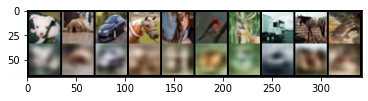

In [15]:
x, _ = iter(testloader).next()
with torch.no_grad():
    pos_p, pos_h = rbm(x[:10].reshape(-1, N_dim))
    recons, rec_h = rbm.gibbs_k(pos_h, k=1, prob=True)
x_all = torch.cat([x[:10], recons.reshape(-1, C, H, W)], dim=2)
canvas = torchvision.utils.make_grid(x_all, nrow=10)
plt.imshow(canvas.permute(1, 2, 0))
print(f"Data entropy={torch.distributions.Bernoulli(pos_p).entropy().sum(dim=-1).mean()}")
print(f"Model entropy={torch.distributions.Bernoulli(rec_h).entropy().sum(dim=-1).mean()}")

Sample entropy=8.74669075012207


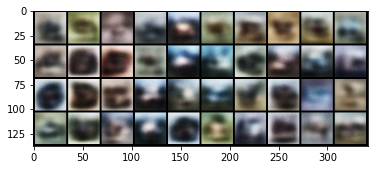

In [16]:
z = torch.rand(40, D)
recons, rec_h = rbm.gibbs_k(z, k=5000, prob=True)
canvas = torchvision.utils.make_grid(recons.reshape(-1, C, H, W), nrow=10)
plt.imshow(canvas.permute(1, 2, 0))
print(f"Sample entropy={torch.distributions.Bernoulli(rec_h).entropy().sum(dim=-1).mean()}")